# Hyperparameter Tuning: Learning Rate y Métricas

¡Bienvenido a esta primera exploración del hyperparameter tuning utilizando el dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)! Este dataset consiste en 60,000 imágenes a color de 32x32 en 10 clases (6,000 imágenes por clase). Aquí están las clases del dataset, así como 10 imágenes aleatorias de cada una: 

![](./nb_image/cifar10.png)

En este notebook, te enfocarás específicamente en el learning rate, un hiperparámetro esencial que dicta el ritmo al que un modelo aprende durante el training. Trabajarás con una simple convolutional neural network (CNN) y observarás cómo los cambios en los hiperparámetros afectan los resultados del modelo.

Este laboratorio cubrirá lo siguiente:

* Examinar los efectos de diferentes learning rates en el rendimiento del modelo.

* Introducir y utilizar métricas adicionales como precision, recall, y F1 score para una evaluación más completa.

* Explorar el efecto del batch size en diferentes métricas utilizando un dataset desbalanceado en una sección opcional.

## Imports

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics

import helper_utils

helper_utils.set_seed(42)

In [3]:
# # Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Learning Rate Optimization on CIFAR-10

Ahora explorarás cómo el learning rate afecta el rendimiento de una simple convolutional neural network (CNN) en el dataset CIFAR-10.
Para ello, entrenarás un modelo CNN simple con diferentes learning rates y observarás el validation accuracy para comprender la sensibilidad del modelo a este hiperparámetro.

El código a continuación establece las funciones necesarias para entrenar el modelo y evaluar su rendimiento:

- `SimpleCNN`: define una arquitectura pequeña de convolutional neural network.

- `evaluate_accuracy`: calcula el accuracy en un dataset de validación.

Estas funciones encapsulan los elementos clave requeridos para ejecutar los experimentos de optimización de hiperparámetros.

In [4]:
class SimpleCNN(nn.Module):
    """Una arquitectura simple de Red Neuronal Convolucional (CNN).

    Esta clase define una CNN de dos capas con max pooling, dropout y
    capas totalmente conectadas, adecuada para tareas básicas de clasificación de imágenes.
    """
    def __init__(self):
        """Inicializa las capas de la red neuronal."""
        # Inicializa la clase padre nn.Module
        super(SimpleCNN, self).__init__()
        # Primera capa convolucional (3 canales de entrada, 16 de salida, kernel de 3x3)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Segunda capa convolucional (16 canales de entrada, 32 de salida, kernel de 3x3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Capa de max pooling con una ventana de 2x2 y stride de 2
        self.pool = nn.MaxPool2d(2, 2)
        # Primera capa totalmente conectada (linear)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        # Segunda capa totalmente conectada (linear), que sirve como capa de salida
        self.fc2 = nn.Linear(64, 10)
        # Capa de Dropout para regularización
        self.dropout = nn.Dropout(p=0.4)
         
    def forward(self, x):
        """Define el forward pass de la red.

        Args:
            x (torch.Tensor): El tensor de entrada con forma (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Los logits de salida de la red.
        """
        # Aplica la primera convolución, activación ReLU y max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Aplica la segunda convolución, activación ReLU y max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Aplana (Flatten) los mapas de características para las capas totalmente conectadas
        x = x.view(-1, 32 * 8 * 8)
        # Aplica la primera capa totalmente conectada con activación ReLU
        x = F.relu(self.fc1(x))
        # Aplica dropout para regularización
        x = self.dropout(x)
        # Aplica la capa de salida final
        x = self.fc2(x)
        return x


def evaluate_accuracy(model, val_loader, device):
    """Calcula el accuracy de un modelo en un dataset dado.

    Args:
        model (nn.Module): El modelo de PyTorch a ser evaluado.
        val_loader (DataLoader): El DataLoader que contiene los datos de validación o prueba.
        device: El dispositivo (ej., 'cuda' o 'cpu') para realizar la evaluación.

    Returns:
        float: El accuracy calculado del modelo en el dataset.
    """
    # Establece el modelo en modo de evaluación (evaluation mode)
    model.eval()
    # Inicializa contadores para el cálculo del accuracy
    total_correct = 0
    total_samples = 0

    # Desactiva el cálculo de gradientes para la evaluación
    with torch.no_grad():
        # Itera sobre los datos en el loader proporcionado
        for inputs, labels in val_loader:
            # Mueve los tensores de entrada y etiquetas al dispositivo especificado
            inputs, labels = inputs.to(device), labels.to(device)
            # Realiza un forward pass para obtener las salidas del modelo
            outputs = model(inputs)

            # Obtiene la clase predicha encontrando el índice del logit máximo
            _, predicted = outputs.max(1)
            # Actualiza el conteo de muestras clasificadas correctamente
            total_correct += (predicted == labels).sum().item()
            # Actualiza el número total de muestras procesadas
            total_samples += labels.size(0)

    # Calcula el accuracy final
    accuracy = total_correct / total_samples
    # Retorna el accuracy calculado
    return accuracy

En el código a continuación, la función `train_and_evaluate`:

- define el modelo.
- configura el optimizer con un learning rate especificado y define la loss function.
- prepara los dataloaders de entrenamiento (train) y validación.
- entrena el modelo por un número especificado de epochs.
- evalúa el rendimiento del modelo en el conjunto de validación (validation set).

Las funciones `get_dataset_dataloaders` y `train_model` se importan de `helper_utils` y se encargan de la preparación del dataset y del entrenamiento del modelo, respectivamente.

In [5]:
def train_and_evaluate(learning_rate, device, n_epochs=25, batch_size=128):
    """Entrena y evalúa un modelo para un learning rate y configuración específicos.

    Esta función orquesta todo el flujo de trabajo: establece una semilla aleatoria,
    inicializa el modelo, el optimizer y los dataloaders, entrena el modelo
    y finalmente evalúa su accuracy en un conjunto de validación.

    Args:
        learning_rate (float): El learning rate a usar para el optimizer.
        device: El dispositivo (ej., 'cuda' o 'cpu') para el entrenamiento y la evaluación.
        n_epochs (int, opcional): El número de epochs para el entrenamiento. Por defecto es 25.
        batch_size (int, opcional): El batch size para los dataloaders. Por defecto es 128.

    Returns:
        float: El accuracy de validación final del modelo entrenado.
    """
    # Establece la semilla aleatoria para reproducibilidad
    helper_utils.set_seed(42)

    # Inicializa el modelo CNN y lo mueve al dispositivo especificado
    model = SimpleCNN().to(device)

    # Define la función de pérdida (loss function)
    loss_fcn = nn.CrossEntropyLoss()

    # Define el optimizer con el learning rate dado
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepara los dataloaders de entrenamiento (train) y validación (val)
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Llama al bucle de entrenamiento principal para entrenar el modelo
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs) 

    # Evalúa el accuracy del modelo entrenado en el conjunto de validación
    accuracy = evaluate_accuracy(model=model, val_loader=val_dataloader, device=device)

    # Imprime los resultados finales para esta configuración
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}"
    )
    # Retorna el accuracy calculado
    return accuracy

Se utilizan algunos learning rates diferentes, desde un valor bajo ($10^{-5}$) hasta uno alto ($10^{-1}$).

Para cada learning rate, el modelo se entrena durante **25 epochs** con un **batch size de 128**.
Después del entrenamiento, el modelo se evalúa en el conjunto de validación (validation set) para calcular el validation accuracy.

In [6]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1] # low to high
accuracies = []

for lr in learning_rates:
    acc = train_and_evaluate(learning_rate=lr, device=device)
    accuracies.append(acc)

100%|██████████| 170M/170M [00:10<00:00, 16.3MB/s] 
/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2604
Epoch 10 - Train Loss: 2.1799
Epoch 15 - Train Loss: 2.1047
Epoch 20 - Train Loss: 2.0460
Epoch 25 - Train Loss: 1.9959
Training complete!

Learning Rate: 1e-05, Accuracy: 0.3240


/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9065
Epoch 10 - Train Loss: 1.6965
Epoch 15 - Train Loss: 1.5812
Epoch 20 - Train Loss: 1.5116
Epoch 25 - Train Loss: 1.4459
Training complete!

Learning Rate: 0.0001, Accuracy: 0.4870


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5280
Epoch 10 - Train Loss: 1.3756
Epoch 15 - Train Loss: 1.2216
Epoch 20 - Train Loss: 1.1272
Epoch 25 - Train Loss: 0.9985
Training complete!

Learning Rate: 0.001, Accuracy: 0.5835


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6790
Epoch 10 - Train Loss: 1.5660
Epoch 15 - Train Loss: 1.4864
Epoch 20 - Train Loss: 1.4197
Epoch 25 - Train Loss: 1.3182
Training complete!

Learning Rate: 0.01, Accuracy: 0.4335


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.3090
Epoch 10 - Train Loss: 2.3106
Epoch 15 - Train Loss: 2.3088
Epoch 20 - Train Loss: 2.3106
Epoch 25 - Train Loss: 2.3086
Training complete!

Learning Rate: 0.1, Accuracy: 0.1050


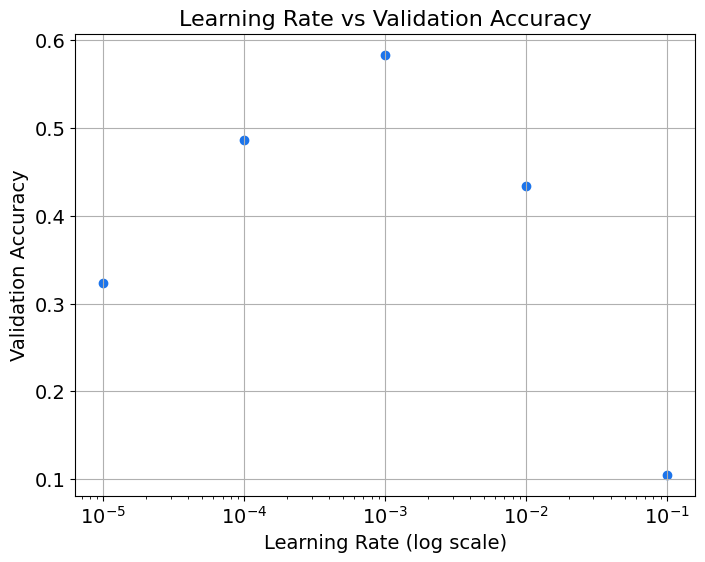

In [7]:
helper_utils.plot_results(learning_rates, accuracies)

<br>

El gráfico muestra que el learning rate de 0.001 proporciona el validation accuracy más alto, lo que indica que es la **opción óptima** entre los valores probados.

Learning rates más pequeños conducen a un aprendizaje más lento y a un accuracy menor, lo que sugiere que el optimizer tardará mucho tiempo en converger.
Learning rates más grandes resultan en un entrenamiento inestable y un accuracy más bajo.

## Otras métricas relevantes: Recall, Precision y F1 Score

Los modelos de Deep Learning se entrenan típicamente optimizando una *loss function*, como la **cross-entropy loss**.
Esta pérdida cuantifica la diferencia entre las probabilidades predichas y las etiquetas reales, guiando al modelo para ajustar sus parámetros.
Proporciona una pérdida escalar que puede minimizarse utilizando algoritmos de optimización basados en gradientes.

Sin embargo, la loss function optimizada durante el entrenamiento no siempre se alinea con las **métricas de evaluación** que te interesan en la práctica. Métricas como **accuracy**, **precision**, **recall** y **F1 score** ofrecen una comprensión más matizada del rendimiento del modelo.

- **Accuracy**: La relación entre las predicciones correctas y el número total de predicciones.
Pero puede ser engañosa en **datasets desbalanceados**, donde el modelo puede lograr un accuracy alto simplemente prediciendo la clase mayoritaria.

- **Precision y Recall**:
Estas métricas evalúan el rendimiento **por clase**, ofreciendo una mejor visión de los comportamientos específicos de cada una.
Para cada clase $k$:
  $$
  \text{Precision}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}
  $$
  $$
  \text{Recall}_k = \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}
  $$

  

  Donde:
  - **TPₖ** (True Positives): Predicciones correctas para la clase $k$.
  - **FPₖ** (False Positives): Instancias predichas incorrectamente como clase $k$.
  - **FNₖ** (False Negatives): Instancias que pertenecen realmente a la clase $k$ pero fueron predichas como otra clase.
  
  

  Para evaluar el rendimiento general en un entorno multiclase, estas métricas pueden agregarse:

  - **Macro-average**:
    Promedia las métricas de todas las clases, tratando a todas por igual. *Útil cuando el balance de clases es importante.*
      - Se usa a menudo para **Precision, Recall y F1** para evitar que la clase mayoritaria domine la puntuación.

  - **Micro-average**:
    Calcula las métricas globalmente agregando todos los TP, FP y FN. *Útil cuando los tamaños de las clases varían significativamente.*
    - El **Accuracy estándar** se calcula usando este método (Total de correctos / Total de muestras).

  - **Weighted-average**:
    Promedia las métricas entre las clases, ponderadas por el número de instancias reales por clase. *Equilibra la influencia tanto de las clases mayoritarias como de las minoritarias.*
    - Usa esto cuando quieras una métrica que refleje la **distribución real de los datos**, asegurando que el rendimiento en las clases comunes contribuya proporcionalmente más a la puntuación final que las clases raras.

- **F1 Score**:
  Combina precision y recall en un solo número, útil cuando tanto los falsos positivos como los falsos negativos son importantes:
  $$
  \text{F1}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
  $$
  Al igual que precision y recall, se puede agregar (macro, micro, weighted) dependiendo del objetivo de la evaluación.



Todas estas métricas van de 0 a 1, donde valores más altos indican un mejor rendimiento. El objetivo es maximizar cada métrica.

Algunos casos de uso para estas métricas incluyen:

- **Precision** es esencial cuando los **falsos positivos** son costosos (ej., detección de spam, diagnóstico médico).
- **Recall** es vital cuando los **falsos negativos** son costosos (ej., tamizaje de enfermedades, detección de fraudes).
- **F1 score** es ideal cuando tanto los falsos positivos como los falsos negativos importan, ya que proporciona un equilibrio entre ambos.

## Ejercicio: Implementando Métricas en PyTorch

La siguiente función `evaluate_metrics` está diseñada para evaluar el rendimiento de un modelo en un dataset de validación utilizando varias métricas como accuracy, precision, recall y F1 score.

Tu ejercicio consiste en completar la función `evaluate_metrics`, la cual calcula métricas clave de rendimiento para un modelo utilizando la librería `torchmetrics`.

**Tu Tarea**:

* **Inicializar las métricas**:
    * En el primer bloque de código, crea instancias para **precision, recall y F1 score** utilizando las clases correspondientes de `torchmetrics`.
    * Para cada métrica, asegúrate de configurar los parámetros correctamente: `task="multiclass"`, `num_classes=num_classes`, y `average="macro"`.
        * **Nota**: El `accuracy_metric` ya está inicializado para ti con `average="micro"` (accuracy estándar).
>
* **Actualizar las métricas en el bucle (loop)**:
    * Dentro del segundo bloque de código, dentro del bucle `for`, debes actualizar cada métrica con los resultados del batch actual.
    * Llama al método `.update()` en tus objetos `precision_metric`, `recall_metric` y `f1_metric`, pasando los valores predichos y las etiquetas reales (true labels).
>
* **Calcular los puntajes finales**:
    * En el bloque de código final, una vez que el bucle de evaluación haya terminado, calcula el valor final para cada métrica.
    * Llama al método `.compute()` para cada métrica y luego usa `.item()` para obtener el resultado escalar final y asignarlo a las variables `precision`, `recall` y `f1`.

In [ ]:
def evaluate_metrics(model, val_dataloader, device, num_classes=10):
    """Evalúa el modelo en un dataset dado utilizando múltiples métricas.

    Args:
        model (torch.nn.Module): El modelo de PyTorch a ser evaluado.
        val_dataloader (DataLoader): El DataLoader que contiene los datos de validación.
        device (torch.device): El dispositivo (ej., 'cuda' o 'cpu') para ejecutar la evaluación.
        num_classes (int, opcional): El número de clases en el dataset. Por defecto es 10.

    Returns:
        tuple: Una tupla que contiene el accuracy, precision, recall y F1 score calculados.
    """
    # Establece el modelo en modo de evaluación
    model.eval()
    
    # Inicializa la métrica de accuracy
    # Por defecto, average es "micro" (accuracy estándar), 
    # pero se establece explícitamente como "average='micro'" por claridad
    accuracy_metric = torchmetrics.Accuracy(
        task="multiclass", num_classes=num_classes, average="micro"
    ).to(device)
    
    ### INICIO DEL CÓDIGO AQUÍ ###
    
    # Inicializa la métrica de precision usando `torchmetrics.Precision`
    # Configura average como "macro" para calcular la métrica por cada clase de forma independiente y luego promediarlas
    precision_metric = torchmetrics.Precision(
        task = "multiclass", num_classes = num_classes, average = "macro"
    ).to(device)
    
    # Inicializa la métrica de recall usando `torchmetrics.Recall`
    # Configura average como "macro" para calcular la métrica por cada clase de forma independiente y luego promediarlas
    recall_metric = torchmetrics.Recall(
        task = "multiclass", num_classes = num_classes, average = "macro"
    ).to(device)
    
    # Inicializa la métrica de F1 score usando `torchmetrics.F1Score`
    # Configura average como "macro" para calcular la métrica por cada clase de forma independiente y luego promediarlas
    f1_metric = torchmetrics.F1Score(
        task = "multiclass", num_classes = num_classes, average = "macro"
    ).to(device)
    
    ### FIN DEL CÓDIGO AQUÍ ###

    # Desactiva el cálculo de gradientes durante la evaluación
    with torch.no_grad():
        # Itera sobre el dataloader de validación
        for inputs, labels in val_dataloader:
            # Mueve las entradas y etiquetas al dispositivo especificado
            inputs, labels = inputs.to(device), labels.to(device)
            # Obtiene las predicciones del modelo
            outputs = model(inputs)
            # Obtiene la clase predicha encontrando el índice del logit máximo
            _, predicted = torch.max(outputs, 1)

            # Actualiza las métricas con las predicciones y etiquetas reales para el batch actual
            accuracy_metric.update(predicted, labels)
            
    ### INICIO DEL CÓDIGO AQUÍ ###
            
            # Actualiza `precision_metric` usando el método `.update` 
            # Conclusion propia: Guarda los resultados 
            precision_metric.update(predicted, labels)
            
            # Actualiza `recall_metric` usando el método `.update`
            recall_metric.update(predicted, labels)
            
            # Actualiza `f1_metric` usando el método `.update`
            f1_metric.update(predicted, labels)
             
    # Calcula las métricas finales sobre todo el dataset
    # Conclusion propia: Hace el calculo final de las metricas luego de haber guardado los resultados
    accuracy = accuracy_metric.compute().item()
    
    # Calcula precision usando el método `.compute` y obtén el valor con `.item()`
    precision = precision_metric.compute().item()
    
    # Calcula recall usando el método `.compute` y obtén el valor con `.item()`
    recall = recall_metric.compute().item()
    
    # Calcula F1 score usando el método `.compute` y obtén el valor con `.item()`
    f1 = f1_metric.compute().item()
    
    ### FIN DEL CÓDIGO AQUÍ ###

    return accuracy, precision, recall, f1

<br>

<details>
<summary><span style="color:green;"><strong>Solution (Click here to expand)</strong></span></summary>

```python
def evaluate_metrics(model, val_dataloader, device, num_classes=10):
    """Evaluates the model on a given dataset using multiple metrics.

    Args:
        model (torch.nn.Module): The PyTorch model to be evaluated.
        val_dataloader (DataLoader): The DataLoader containing the validation data.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run the evaluation on.
        num_classes (int, optional): The number of classes in the dataset. Defaults to 10.

    Returns:
        tuple: A tuple containing the computed accuracy, precision, recall, and F1 score.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize accuracy metric
    # By default average is "micro" (standard accuracy), 
    # but explicitly setting it as "average='micro'" for clarity
    accuracy_metric = torchmetrics.Accuracy(
        task="multiclass", num_classes=num_classes, average="micro"
    ).to(device)
    
    ### START CODE HERE ###
    
    # Initialize precision metric using `torchmetrics.Precision`
    # Set average as "macro" to calculate the metric for each class independently and then average them
    precision_metric = torchmetrics.Precision(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize recall metric using `torchmetrics.Recall`
    # Set average as "macro" to calculate the metric for each class independently and then average them
    recall_metric = torchmetrics.Recall(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    # Initialize F1 score metric using `torchmetrics.F1Score`
    # Set average as "macro" to calculate the metric for each class independently and then average them
    f1_metric = torchmetrics.F1Score(
        task="multiclass", num_classes=num_classes, average="macro"
    ).to(device)
    
    ### END CODE HERE ###

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the validation dataloader
        for inputs, labels in val_dataloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            # Get model predictions
            outputs = model(inputs)
            # Get the predicted class by finding the index of the maximum logit
            _, predicted = torch.max(outputs, 1)

            # Update metrics with the predictions and true labels for the current batch
            accuracy_metric.update(predicted, labels)
            
    ### START CODE HERE ###
            
            # Update `precision_metric` using `.update` method 
            precision_metric.update(predicted, labels)
            
            # Update `recall_metric` using `.update` method
            recall_metric.update(predicted, labels)
            
            # Update `f1_metric` using `.update` method
            f1_metric.update(predicted, labels)
             
    # Compute the final metrics over the entire dataset
    accuracy = accuracy_metric.compute().item()
    
    # Compute precision using `.compute` method and get the value with `.item()`
    precision = precision_metric.compute().item()
    
    # Compute recall using `.compute` method and get the value with `.item()`
    recall = recall_metric.compute().item()
    
    # Compute F1 score using `.compute` method and get the value with `.item()`
    f1 = f1_metric.compute().item()
    
    ### END CODE HERE ###

    return accuracy, precision, recall, f1
```

<br>

In [9]:
# CHECK YOUR IMPLEMENTATION

# model
model = SimpleCNN().to(device)

# dataloaders
train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=128)

accuracy, precision, recall, f1 = evaluate_metrics(model=model, val_dataloader=val_dataloader, device=device)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Accuracy: 0.1080, Precision: 0.0179, Recall: 0.0980, F1 Score: 0.0274


#### Expected Output (approximate values):

```
Accuracy: 0.1030, Precision: 0.0103, Recall: 0.1000, F1 Score: 0.0187
```

### Cómo cambian otras métricas con el learning rate

*¿Cómo cambian estas métricas con diferentes learning rates?* Para explorar esto, entrenarás el modelo con los mismos cinco learning rates y lo evaluarás utilizando accuracy, precision, recall y F1 score.

Se ha definido una nueva función `train_and_evaluate_metrics` para gestionar el proceso de entrenamiento y evaluación.

In [10]:
def train_and_evaluate_metrics(learning_rate, device, n_epochs=25, batch_size=128, imbalanced=False):
    """Entrena y evalúa un modelo, devolviendo un conjunto completo de métricas.

    Esta función orquesta el pipeline de machine learning de extremo a extremo para una
    configuración dada. Establece una semilla aleatoria, inicializa el modelo y los
    componentes relacionados, carga los datos, ejecuta el bucle de entrenamiento (training loop)
    y evalúa el rendimiento del modelo usando accuracy, precision, recall y F1-score.

    Args:
        learning_rate (float): El learning rate para el optimizer.
        device: El dispositivo (ej., 'cuda' o 'cpu') para el entrenamiento y la evaluación.
        n_epochs (int, opcional): El número de epochs de entrenamiento. Por defecto es 25.
        batch_size (int, opcional): El batch size para los dataloaders. Por defecto es 128.
        imbalanced (bool, opcional): Una bandera (flag) para usar un dataset desbalanceado.
                                     Por defecto es False.

    Returns:
        tuple: Una tupla que contiene el accuracy de validación final, precision,
               recall y F1-score.
    """
    # Establece la semilla aleatoria para reproducibilidad
    helper_utils.set_seed(42)

    # Inicializa el modelo CNN y lo mueve al dispositivo especificado
    model = SimpleCNN().to(device)

    # Define la función de pérdida (loss function) para el entrenamiento
    loss_fcn = nn.CrossEntropyLoss()

    # Define el optimizer con el learning rate especificado
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepara los dataloaders de entrenamiento (train) y validación (val)
    train_dataloader, val_dataloader = helper_utils.get_dataset_dataloaders(batch_size=batch_size, imbalanced=imbalanced)

    # Llama al bucle de entrenamiento principal para entrenar el modelo
    helper_utils.train_model(model=model, optimizer=optimizer, loss_fcn=loss_fcn, train_dataloader=train_dataloader, device=device, n_epochs=n_epochs) 

    # Evalúa el modelo entrenado para obtener el conjunto completo de métricas de rendimiento
    accuracy, precision, recall, f1 = evaluate_metrics(model, val_dataloader, device)

    # Imprime los resultados finales para esta configuración
    print(
        f"Learning Rate: {learning_rate}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
    )
    # Retorna las métricas de rendimiento calculadas
    return accuracy, precision, recall, f1

Para cada learning rate, el modelo se entrena durante **25 epochs** y el batch size es igual a **128**.
Después del entrenamiento, el modelo se evalúa en el conjunto de validación (validation set) para calcular el accuracy, precision, recall y F1 score.

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.2604
Epoch 10 - Train Loss: 2.1799
Epoch 15 - Train Loss: 2.1047
Epoch 20 - Train Loss: 2.0460
Epoch 25 - Train Loss: 1.9959
Training complete!

Learning Rate: 1e-05, Accuracy: 0.3240, Precision: 0.3234, Recall: 0.3235, F1: 0.2850


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.9065
Epoch 10 - Train Loss: 1.6965
Epoch 15 - Train Loss: 1.5812
Epoch 20 - Train Loss: 1.5116
Epoch 25 - Train Loss: 1.4459
Training complete!

Learning Rate: 0.0001, Accuracy: 0.4870, Precision: 0.4838, Recall: 0.4850, F1: 0.4789


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.5280
Epoch 10 - Train Loss: 1.3756
Epoch 15 - Train Loss: 1.2216
Epoch 20 - Train Loss: 1.1272
Epoch 25 - Train Loss: 0.9985
Training complete!

Learning Rate: 0.001, Accuracy: 0.5835, Precision: 0.5815, Recall: 0.5806, F1: 0.5764


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.6790
Epoch 10 - Train Loss: 1.5660
Epoch 15 - Train Loss: 1.4864
Epoch 20 - Train Loss: 1.4197
Epoch 25 - Train Loss: 1.3182
Training complete!

Learning Rate: 0.01, Accuracy: 0.4335, Precision: 0.4255, Recall: 0.4297, F1: 0.4202


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 2.3090
Epoch 10 - Train Loss: 2.3106
Epoch 15 - Train Loss: 2.3088
Epoch 20 - Train Loss: 2.3106
Epoch 25 - Train Loss: 2.3086
Training complete!

Learning Rate: 0.1, Accuracy: 0.1050, Precision: 0.0105, Recall: 0.1000, F1: 0.0190


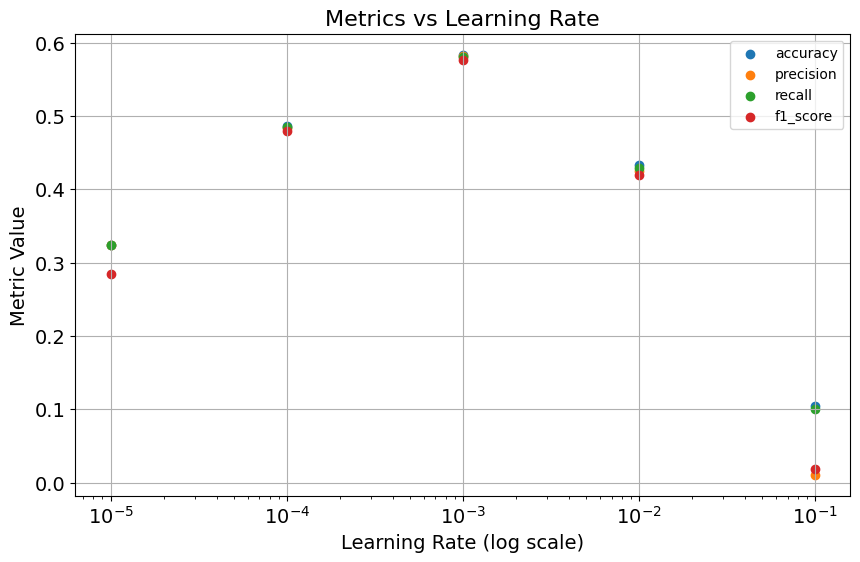

In [11]:
dict_metrics = []

# Bucle a través de diferentes learning rates y recolección de métricas
for lr in learning_rates:

    # Entrenar y evaluar el modelo, recolectando métricas, para un learning rate dado
    n_epochs = 25
    batch_size = 128
    acc, prec, rec, f1 = train_and_evaluate_metrics(learning_rate=lr, device=device, n_epochs=n_epochs, batch_size=batch_size)

    metrics_lr = {
        "learning_rate": lr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }

    dict_metrics.append(metrics_lr)

# Convertir la lista de diccionarios a un DataFrame para facilitar el trazado de gráficos
df_metrics = pd.DataFrame(dict_metrics)

# Graficar las métricas frente al learning rate
helper_utils.plot_metrics_vs_learning_rate(df_metrics)

<br>

En este caso, dado que el dataset está balanceado, puedes observar que todas las métricas (accuracy, precision, recall, F1-score) se comportan de manera similar para la mayoría de los learning rates, y el valor de $10^{-3}$ logra el mejor rendimiento en todos los aspectos.

## (Opcional) Exploración Adicional: Optimización del Batch Size en un Dataset Desbalanceado

En esta sección, retomarás los experimentos anteriores con la siguiente configuración:

- **Learning Rate:** se establecerá en $10^{−3}$.
- **Dataset Desbalanceado (Imbalanced Dataset):** Trabajarás con un subconjunto personalizado del dataset CIFAR-10 para observar mejor cómo las métricas se ven afectadas por el desbalance de clases.

La nueva variable que explorarás es el **Batch Size**. Variarás sus valores (32, 64 y 128) para ver cómo influyen en las diferentes métricas de rendimiento.

**Dataset CIFAR-10 con Desbalance de Clases**
Para este experimento, se ha diseñado un subconjunto del dataset CIFAR-10 para simular un desbalance de clases, enfocándose en tres clases: `Cat` (Gato), `Dog` (Perro) y `Frog` (Rana). Para imitar un escenario donde algunas clases son más prevalentes, el dataset incluye todas las instancias disponibles de `Cat`, mientras que reduce el número de muestras para las otras dos clases. Específicamente, se conserva el 50% de las imágenes originales de `Dog` y solo el 20% de las imágenes de `Frog`. Como resultado, el dataset comprende:

- 6,000 imágenes de `Cat`
- 3,000 imágenes de `Dog`
- 1,200 imágenes de `Frog`

Esta configuración crea un desbalance pronunciado, resaltando la clase `Cat` y reflejando situaciones del mundo real donde ciertas clases están subrepresentadas.

In [12]:
# Esta celda tardará aproximadamente 15 minutos.

dict_metrics = []

# Bucle a través de diferentes batch sizes y recolección de métricas
batch_sizes = [32, 64, 128]

# Establecer un learning rate fijo
lr = 0.001  # Learning rate medio

# Establecer imbalanced en True para usar el dataset desbalanceado
imbalanced = True

n_epochs = 25

for bs in batch_sizes:
    # Entrenar y evaluar el modelo, recolectando métricas, para un batch size dado
    acc, prec, rec, f1 = train_and_evaluate_metrics(batch_size=bs, n_epochs=n_epochs, learning_rate=lr, device=device, imbalanced=imbalanced)

    metrics_bs = {
        "batch_size": bs,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
    }
    dict_metrics.append(metrics_bs)

# Convertir la lista de diccionarios a un DataFrame para facilitar el análisis
df_metrics = pd.DataFrame(dict_metrics)

Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/213 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.6701
Epoch 10 - Train Loss: 0.5578
Epoch 15 - Train Loss: 0.4475
Epoch 20 - Train Loss: 0.3315
Epoch 25 - Train Loss: 0.2372
Training complete!

Learning Rate: 0.001, Accuracy: 0.7147, Precision: 0.7132, Recall: 0.6657, F1: 0.6815


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.7070
Epoch 10 - Train Loss: 0.6089
Epoch 15 - Train Loss: 0.5190
Epoch 20 - Train Loss: 0.4311
Epoch 25 - Train Loss: 0.3321
Training complete!

Learning Rate: 0.001, Accuracy: 0.7188, Precision: 0.7267, Recall: 0.6509, F1: 0.6735


Current Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.7590
Epoch 10 - Train Loss: 0.6612
Epoch 15 - Train Loss: 0.5909
Epoch 20 - Train Loss: 0.5391
Epoch 25 - Train Loss: 0.4685
Training complete!

Learning Rate: 0.001, Accuracy: 0.7241, Precision: 0.7300, Recall: 0.6699, F1: 0.6920


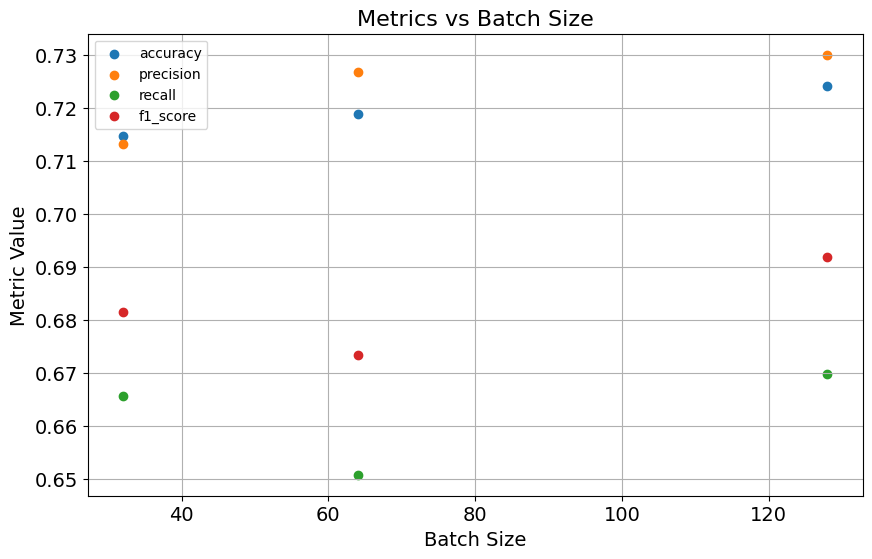

In [13]:
helper_utils.plot_metrics_vs_batch_size(df_metrics)

<br>

Observa que el batch size óptimo depende significativamente de la métrica que se esté priorizando. **Es común encontrar que un batch size puede optimizar una métrica en particular, mientras que un batch size diferente produce mejores resultados para otra**. En conclusión, *un parámetro que es óptimo para una métrica podría no serlo para otra*.

## Conclusion

¡Felicitaciones por completar este ejercicio de hyperparameter tuning! En este notebook, exploraste el impacto de variar los learning rates en el rendimiento de una CNN entrenada con el dataset CIFAR-10. 
Al ajustar el learning rate, observaste cambios en el validation accuracy y conociste métricas de evaluación alternativas como precision, recall y F1 score. 

Además, exploraste los efectos del batch size en el rendimiento del modelo utilizando un subconjunto desbalanceado (imbalanced subset) del dataset CIFAR-10.

Esta experiencia ha profundizado tu comprensión sobre la importancia de la selección del learning rate en el entrenamiento de modelos y ha resaltado la utilidad de métricas integrales para evaluar el rendimiento del modelo.